In [1]:
import torch
print(torch.__version__)

2.7.0


In [2]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 

In [3]:
df = pd.read_csv('data/iris.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
# View the description  of the dataframe
df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
# View the top 5 data item
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [7]:
X = df.drop(columns=['Species'])
y = df['Species'].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

In [8]:
X = torch.Tensor(X.values).type(torch.float)
y = torch.Tensor(y.values).type(torch.float)

In [9]:
type(X)

torch.Tensor

In [10]:
type(y)

torch.Tensor

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
print(f"Shape of X_train and y_train {X_train.shape} {y_train.shape}")
print(f"Shape of X_test and y_test {X_test.shape} {y_test.shape}")

Shape of X_train and y_train torch.Size([120, 4]) torch.Size([120])
Shape of X_test and y_test torch.Size([30, 4]) torch.Size([30])


In [13]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device = {device}")

Using device = mps


In [14]:
from torch import nn

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=100):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

In [16]:
model = NeuralNetwork(input_features=4, output_features=3, hidden_units=100)
model.to(device)
list(model.parameters())

[Parameter containing:
 tensor([[-0.3967,  0.3029, -0.4706, -0.4607],
         [-0.2499, -0.2747,  0.4791, -0.2005],
         [ 0.1219,  0.2992,  0.2857, -0.0937],
         [-0.4195, -0.3223,  0.1478,  0.1545],
         [ 0.1173,  0.3961, -0.4729,  0.4476],
         [ 0.2369,  0.4657, -0.1298,  0.2221],
         [ 0.0780,  0.2895,  0.4336,  0.4279],
         [-0.0972, -0.4383,  0.3635,  0.4337],
         [-0.1418, -0.4561, -0.4556, -0.0710],
         [-0.0166, -0.4978, -0.2539,  0.2048],
         [ 0.3708, -0.3007, -0.4444, -0.0149],
         [ 0.3374, -0.0454,  0.3565,  0.1059],
         [ 0.4386, -0.1067, -0.0564, -0.3996],
         [ 0.0711,  0.4492,  0.0055,  0.4240],
         [-0.4935,  0.1053, -0.4189, -0.4145],
         [ 0.2782,  0.2906,  0.2339,  0.1984],
         [ 0.4117, -0.3493, -0.0601,  0.3885],
         [-0.3592, -0.1930, -0.0493,  0.3293],
         [ 0.1083,  0.4317, -0.1893, -0.3377],
         [ 0.0166,  0.4834, -0.3395, -0.1540],
         [ 0.1043, -0.3618, -0.0328, 

In [17]:
# Set up Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [18]:
epochs = 4000
trainLossList = []
testLossList = []
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
    ### TRAINING
    # 1. Forward Pass
    y_logits = model(X_train).squeeze()
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Compute Loss
    loss = loss_fn(y_logits, y_train)

    # 3. Zero grad Optimizer
    optimizer.zero_grad()

    # 4. Backpropagate
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    acc = accuracy_score(y_true=y_train.cpu(), y_pred=y_preds.cpu())

    ### TESTING
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_true=y_test.cpu(), y_pred=test_preds.cpu())

    if (epoch+1)%100 == 0:
        print(f"Epoch={epoch+1}|Train Loss={loss:.4f}|Train Acc={acc:.2f}|Test Loss={test_loss:.4f}|Test Acc={test_acc:.2f}")
    
    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

Epoch=100|Train Loss=0.4807|Train Acc=0.91|Test Loss=0.4734|Test Acc=0.93
Epoch=200|Train Loss=0.3397|Train Acc=0.98|Test Loss=0.3431|Test Acc=0.97
Epoch=300|Train Loss=0.2465|Train Acc=0.98|Test Loss=0.2638|Test Acc=0.97
Epoch=400|Train Loss=0.1830|Train Acc=0.98|Test Loss=0.2120|Test Acc=0.97
Epoch=500|Train Loss=0.1448|Train Acc=0.98|Test Loss=0.1801|Test Acc=0.97
Epoch=600|Train Loss=0.1219|Train Acc=0.98|Test Loss=0.1604|Test Acc=0.97
Epoch=700|Train Loss=0.1074|Train Acc=0.98|Test Loss=0.1475|Test Acc=0.97
Epoch=800|Train Loss=0.0971|Train Acc=0.97|Test Loss=0.1385|Test Acc=0.97
Epoch=900|Train Loss=0.0904|Train Acc=0.97|Test Loss=0.1320|Test Acc=0.97
Epoch=1000|Train Loss=0.0855|Train Acc=0.97|Test Loss=0.1268|Test Acc=0.97
Epoch=1100|Train Loss=0.0818|Train Acc=0.97|Test Loss=0.1225|Test Acc=0.97
Epoch=1200|Train Loss=0.0790|Train Acc=0.97|Test Loss=0.1188|Test Acc=0.97
Epoch=1300|Train Loss=0.0767|Train Acc=0.97|Test Loss=0.1156|Test Acc=0.97
Epoch=1400|Train Loss=0.0748|Train

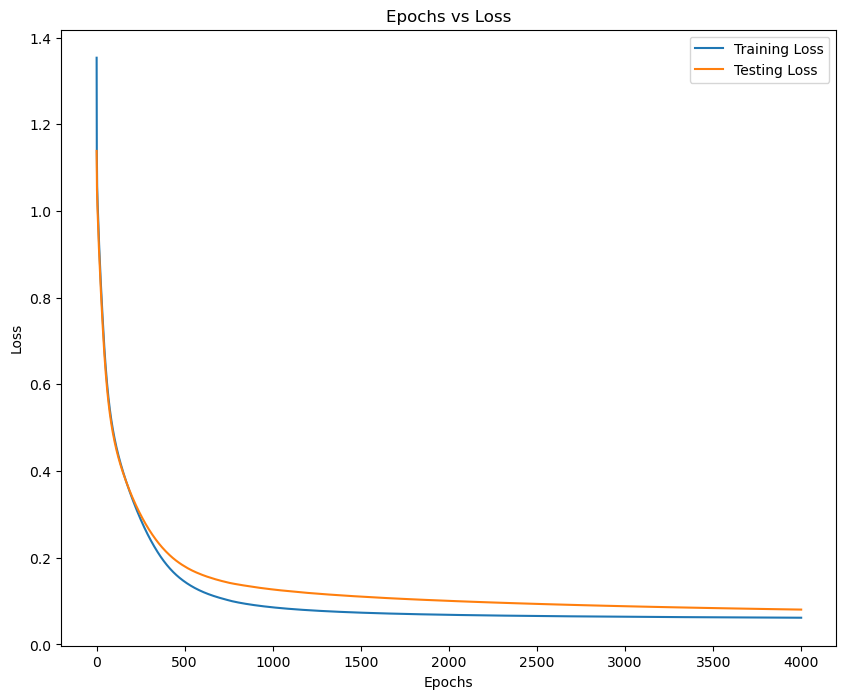

In [19]:
# Plot the Loss Curve
plt.figure(figsize=(10,8))
plt.plot(range(epochs), trainLossList, label="Training Loss")
plt.plot(range(epochs), testLossList, label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.show()

In [20]:
from pathlib import Path 
# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path 
MODEL_NAME = "iris_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [25]:
df.sample()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
22,4.6,3.6,1.0,0.2,Iris-setosa


In [27]:
test_sample = np.array([[4.6, 3.6, 1.0, 0.2]])
test_tensor = torch.from_numpy(test_sample).type(torch.float).to(device)
test_answer = model(test_tensor)
print(test_answer)

tensor([[ 13.2893,   4.8908, -19.9690]], device='mps:0',
       grad_fn=<LinearBackward0>)


In [28]:
test_answer_softmax = torch.softmax(test_answer, dim=1)
print(test_answer_softmax)

tensor([[9.9977e-01, 2.2515e-04, 3.5977e-15]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)


In [ ]:
test_answer_softmax_argmax = torch.argmax(test_answer_softmax, dim=1)
print(test_answer_softmax_argmax)

tensor([0], device='mps:0')


In [35]:
answer = test_answer_softmax_argmax.cpu().numpy()
print(answer[0])

0


In [36]:
label_to_idx = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
idx_to_label= {value:key for key,value in label_to_idx.items()}
print(idx_to_label)

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}


In [37]:
print(idx_to_label[answer[0]])

Iris-setosa
